In [26]:
import os
import json
import random
import networkx as nx
import time

# ----------- CONSTANTS -----------
time_NOT = time_AND = time_OR = time_XOR = cpu_speed = comm_speed = latency = 0
BSP_r = 289
BSP_g = 865
BSP_L = 7755972

def poids(truth_table, time_MOY):
    ref = "00 1\n01 0\n10 0\n11 0"
    return (time_MOY * len(truth_table) / len(ref))

def niveau(G):
    indegree_map = {v: d for v, d in G.in_degree() if d > 0}
    zero_indegree = [v for v, d in G.in_degree() if d == 0]
    while zero_indegree:
        yield zero_indegree
        new_zero_indegree = []
        for v in zero_indegree:
            for _, child in G.edges(v):
                indegree_map[child] -= 1
                if not indegree_map[child]:
                    new_zero_indegree.append(child)
        zero_indegree = new_zero_indegree

def read_blif_file(file_name):
    def parse_blif(lines):
        taches = {}
        cmds = "".join(lines).split('.')
        G = nx.DiGraph()
        for cmd in cmds:
            if cmd.startswith('names'):
                cmd = cmd.strip().split('\n')
                var = cmd[0].split()[1:]
                out = var[-1]
                ins = var[:-1]
                edges = [(v, out) for v in ins]
                G.add_nodes_from(var)
                G.add_edges_from(edges)
                truth_table = "\n".join(cmd[1:]).strip()
                taches[out] = (ins, truth_table)
        return G, taches
    with open(file_name) as f:
        return parse_blif(f.readlines())

def fitness(association, levels, taches, gate_to_id, G, machines_number, in_length, BSP_gs, BSP_Ls, time_MOY):
    W = {}
    H = {}
    cost = 0
    for level in levels:
        for gate in level:
            idd = gate_to_id[gate]
            pi = association[idd]
            poids_val = poids(taches[gate][-1], time_MOY)
            W[pi] = W.get(pi, 0) + poids_val
            for gate1 in G.successors(gate):
                idd1 = gate_to_id[gate1]
                pi1 = association[idd1]
                H[(pi, pi1)] = H.get((pi, pi1), 0) + in_length
    for p in range(machines_number):
        H[(p, p)] = 0
    w = max(W.values(), default=0)
    h = max(H.values(), default=0)
    return float(w + h * BSP_gs + BSP_Ls)

def process_all_graphs(json_dir):
    total_pred_cost = 0.0
    total_opt_cost = 0.0
    count = 0

    for file_name in os.listdir(json_dir):
        if not file_name.endswith("_features.json"):
            continue

        file_path = os.path.join(json_dir, file_name)
        with open(file_path, "r") as f:
            data = json.load(f)

        graph_id = next(iter(data))
        graph_data = data[graph_id]

        # Build path to BLIF
        blif_path = f"dataset000/Logique/{graph_id}.txt"
        if not os.path.exists(blif_path):
            print(f"[SKIPPED] Missing BLIF file: {blif_path}")
            continue

        # Parameters
        fitness_params = graph_data["fitness_params"]
        global time_NOT, time_AND, time_OR, time_XOR, cpu_speed, comm_speed, latency
        in_length = fitness_params["in_length"]
        time_NOT = fitness_params["time_NOT"]
        time_AND = fitness_params["time_AND"]
        time_OR = fitness_params["time_OR"]
        time_XOR = fitness_params["time_XOR"]
        cpu_speed = fitness_params["cpu_speed"]
        comm_speed = fitness_params["comm_speed"]
        latency = fitness_params["latency"]
        nodes = fitness_params["nodes"]
        cores = fitness_params["cores"]

        time_MOY = (time_NOT + time_XOR + time_AND + time_OR) / 4
        BSP_gs = comm_speed / (cpu_speed * 1e6)
        BSP_Ls = latency / (cpu_speed * 1e6)
        machines_number = nodes * cores

        try:
            G, taches = read_blif_file(blif_path)
        except Exception as e:
            print(f"[ERROR] Could not parse {blif_path}: {e}")
            continue

        levels = list(niveau(G))
        levels[0] = [gate for gate in levels[0] if gate in taches]

        gate_to_id = {}
        idd = 0
        for level in levels:
            for gate in level:
                gate_to_id[gate] = idd
                idd += 1

        try:
            optimal_vector = [v for _, v in graph_data["optimal_repartition"]]
            our_model = graph_data["prediction_list"]

            cost_optimal = fitness(optimal_vector, levels, taches, gate_to_id, G, machines_number, in_length, BSP_gs, BSP_Ls, time_MOY)
            cost_model = fitness(our_model, levels, taches, gate_to_id, G, machines_number, in_length, BSP_gs, BSP_Ls, time_MOY)

            # print(f"{file_name} | prediction_cost: {cost_model:.4f} | optimal_cost: {cost_optimal:.4f}")

            total_pred_cost += cost_model
            total_opt_cost += cost_optimal
            count += 1

        except Exception as e:
            print(f"[ERROR] Failed on {file_name}: {e}")

    if count == 0:
        print("No valid files processed.")
        return 0.0, 0.0

    avg_pred = total_pred_cost / count
    avg_opt = total_opt_cost / count
    # print(f"\nAverage prediction cost: {avg_pred:.4f}")
    # print(f"Average optimal cost:    {avg_opt:.4f}")

    return [avg_pred, avg_opt]

In [27]:
import pandas as pd

results = []
rows = []

for i in range(2, 101):
    path = f"graphes_JSON_Complet/{i}/test"
    result = process_all_graphs(path)
    results.append(result)
    rows.append({
        "Machines": i,
        "Prediction Cost": round(result[0], 2),
        "Optimal Cost": round(result[1], 2)
    })

# Create DataFrame
df = pd.DataFrame(rows)

# # Print each row
# for idx, row in df.iterrows():
#     print(f'--- Clusters with {row["Machines"]} machines ---')
#     print(f'AVG Prediction cost | AVG Optimal cost')
#     print(f'{row["Prediction Cost"]:.2f} | {row["Optimal Cost"]:.2f}')

# Compute and print total averages
total_avg_pred = df["Prediction Cost"].mean()
total_avg_optimal = df["Optimal Cost"].mean()
print(f'\nTotal AVG prediction Cost: {total_avg_pred:.2f} | Total AVG optimal Cost: {total_avg_optimal:.2f}')



Total AVG prediction Cost: 59.02 | Total AVG optimal Cost: 48.45


In [28]:
# save to CSV
# df.to_csv("evaluation_results.csv", index=False)


In [29]:
# save to CSV
# df.to_csv("evaluation_results.csv", index=False)


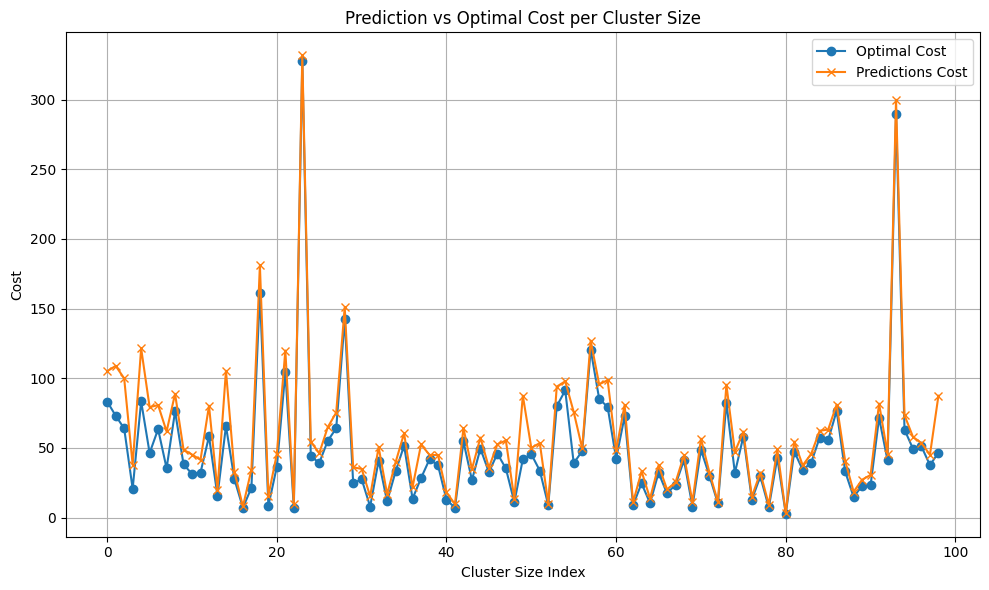

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Optimal Cost'], label='Optimal Cost', marker='o')
plt.plot(df['Prediction Cost'], label='Predictions Cost', marker='x')
plt.title('Prediction vs Optimal Cost per Cluster Size')
plt.xlabel('Cluster Size Index') 
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


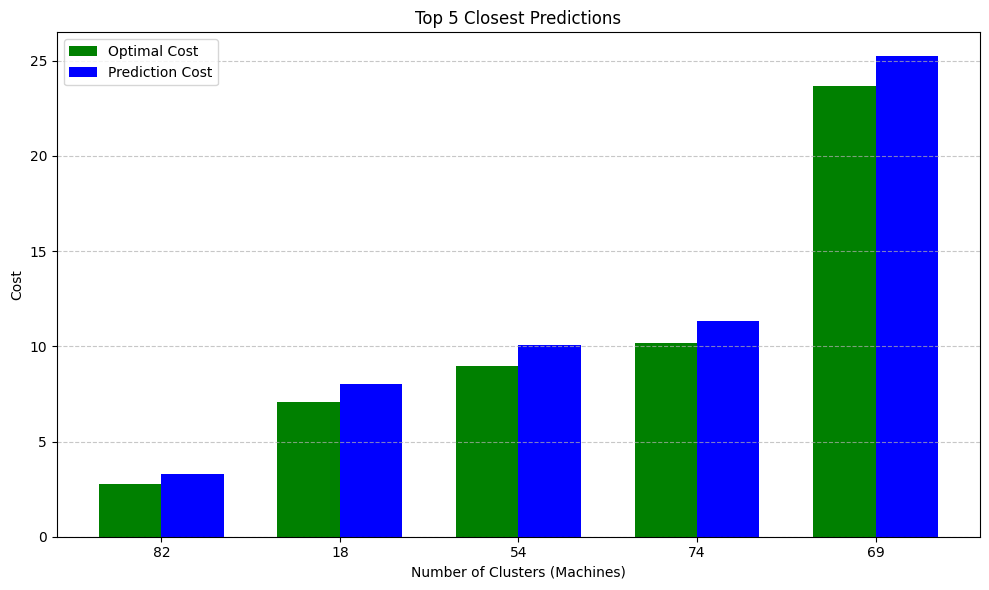

In [31]:
import numpy as np

df['Diff'] = (df['Prediction Cost'] - df['Optimal Cost']).abs()
top_n = 5
df_best = df.sort_values(by='Diff').head(top_n)

# Positions pour les barres
x = np.arange(len(df_best))  # positions des groupes de barres
bar_width = 0.35

plt.figure(figsize=(10, 6))

# Barres pour le coût optimal
plt.bar(x - bar_width/2, df_best['Optimal Cost'], width=bar_width, label='Optimal Cost', color='green')

# Barres pour le coût prédit
plt.bar(x + bar_width/2, df_best['Prediction Cost'], width=bar_width, label='Prediction Cost', color='blue')

# Labels et légendes
plt.xlabel('Number of Clusters (Machines)')
plt.ylabel('Cost')
plt.title(f'Top {top_n} Closest Predictions')
plt.xticks(x, df_best['Machines'])  # labels sur l’axe x
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


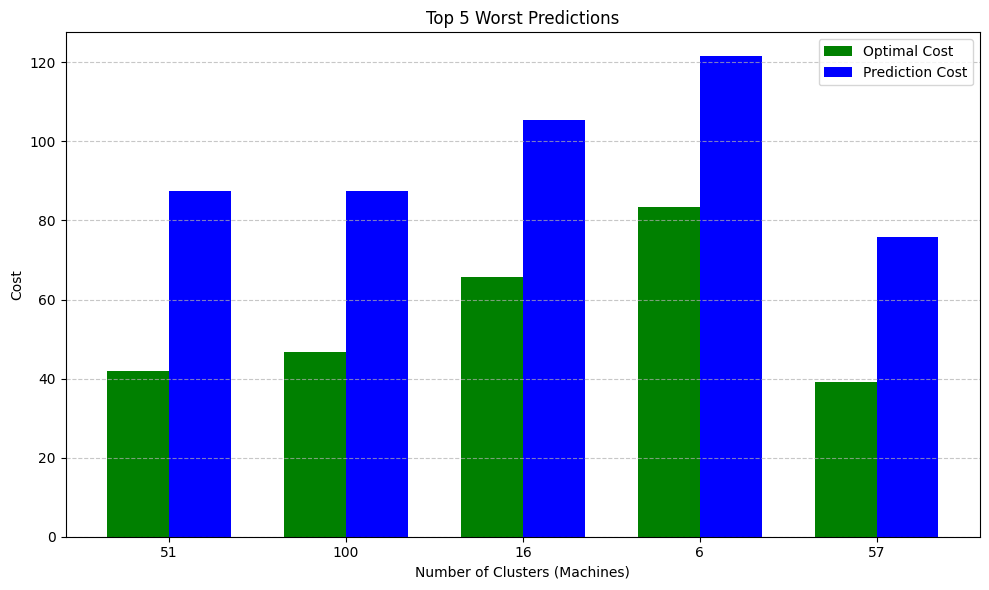

In [32]:
df['Diff'] = (df['Prediction Cost'] - df['Optimal Cost']).abs()

# Get top N worst predictions (largest differences)
top_n = 5
df_worst = df.sort_values(by='Diff', ascending=False).head(top_n)

# Positions pour les barres
x = np.arange(len(df_worst))  # positions des groupes de barres
bar_width = 0.35

plt.figure(figsize=(10, 6))

# Barres pour le coût optimal
plt.bar(x - bar_width/2, df_worst['Optimal Cost'], width=bar_width, label='Optimal Cost', color='green')

# Barres pour le coût prédit
plt.bar(x + bar_width/2, df_worst['Prediction Cost'], width=bar_width, label='Prediction Cost', color='blue')

# Labels et légendes
plt.xlabel('Number of Clusters (Machines)')
plt.ylabel('Cost')
plt.title(f'Top {top_n} Worst Predictions')
plt.xticks(x, df_worst['Machines'])  # labels sur l’axe x
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
